This notebook contains the examples showing:
- how to use the model for processing the microimages in Python
- how to use the web-application API for processing the images 

### 1. Using the model in Python

The requirements are the following:  
- Python >= 3.6
- tensorflow (tensorflow-gpu)
- keras (keras-gpu)
- opencv

#### Import all necessary modules

In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow
from keras.models import load_model
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


#### Load the model

In [2]:
count_model=load_model('model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#### Define the functions for image analysis

In [3]:
## This function is rother slow...
## However it returns not only the cell counts but also the redundant count maps
def count_cells(path2image, 
                count_model = count_model, 
                red_intensity_lower = 50, ## you can change this parameter if you want more sensitivity
                brighten = 40, ## increasing this value you also slightly increase the sensitivity
                return_count_maps = False): 
    padd = 32 ## don't change! it's necessary for the current model
    ## read the image with cells (currently HEK cells)
    cells = cv2.imread(path2image) 
    if cells.shape != (1040, 1392,3): # erronous case, the image selected doesn't fit 
                                      # the size needed (restrictions because of the model), so resize
        cells = cv2.resize(cells, (1040, 1392), interpolation = cv.INTER_CUBIC)
    cellshsv=cv2.cvtColor(cells, cv2.COLOR_BGR2HSV) ## convert the colors
    ## extract the red cells
    red=np.uint8([[[0, 0, 255]]])
    hsv_red = cv2.cvtColor(red,cv2.COLOR_BGR2HSV)
    lower_red = np.array([hsv_red[0][0][0]-10,int(red_intensity_lower),int(red_intensity_lower)])
    upper_red = np.array([hsv_red[0][0][0]+10,255,255])
    ## create the mask
    mask = cv2.inRange(cellshsv, lower_red, upper_red)
    mask = cv2.erode(mask, None, iterations = 3) ## three cycles of erosion
    mask = cv2.dilate(mask, None, iterations = 6) ## six iterations of dilatation
    red_cells = cv2.bitwise_and(cells, cells, mask= mask) ## apply the mask
    target_points = ((red_cells[:,:,0]==0)*(red_cells[:,:,1]==0)*(red_cells[:,:,2]==0))
    point_ind_x, point_ind_y = np.nonzero(target_points)
    if brighten > 0:
        red_cells[:,:,0] += (target_points*brighten ).astype('uint8')
        red_cells = red_cells.clip(min = 0, max = 255)
    red_cells=cv2.cvtColor(red_cells,cv2.COLOR_BGR2RGB)
    ## 
    rsubs = list(map(lambda x: cv2.copyMakeBorder(x,padd,padd,padd,padd,cv2.BORDER_CONSTANT,value=0),
                     [red_cells[:520,:696], red_cells[:520,696:], red_cells[520:,:696], red_cells[520:,696:]]))
    ncells=cv2.cvtColor(cells,cv2.COLOR_BGR2RGB)
    nsubs = list(map(lambda x: cv2.copyMakeBorder(x,padd,padd,padd,padd,cv2.BORDER_CONSTANT,value=0),
                     [ncells[:520,:696], ncells[:520,696:], ncells[520:,:696], ncells[520:,696:]]))
    nir=np.zeros((1040,1392))
    nir[:520,:696], nir[:520,696:], nir[520:,:696], nir[520:,696:] = list (
        map(lambda x: count_model.predict_on_batch(x[None,...])[0,...,0], nsubs))
    rir=np.zeros((1040,1392))
    rir[:520,:696], rir[:520:,696:], rir[520:,:696], rir[520:,696:] = list (
        map(lambda x: count_model.predict_on_batch(x[None,...])[0,...,0], rsubs))    
    allcells = (nir).sum()/(65**2)
    redcells = (rir).sum()/(65**2)
    redprc  = 100 * redcells/allcells
    rslt = {'all_cells'           : allcells, 
            'red_cells'           : redcells,
            'red_%'               : redprc, 
            'red_intensity_lower' : red_intensity_lower,
            'brighten'            : brighten }
    if return_count_maps:
        rslt['cell_map'] = nir
        rslt['red_map']  = rir
    return rslt

## the function below is faster but it does only the one thing -- just counts the cells:
def count_cells2(path2image, 
                 red_intensity_lower = 50, 
                 count_model = count_model, 
                 brighten = 40, fluor = False):
    padd = 32
    cells = cv2.imread(path2image)
    if cells.shape != (1040, 1392,3): # erronous case, the image selected doesn't fit 
                                      # the size needed (restrictions because of the model), so resize
        cells = cv2.resize(cells, (1040, 1392), interpolation = cv.INTER_CUBIC)
    if fluor: ## if you want to count the red cells
        cellshsv=cv2.cvtColor(cells, cv2.COLOR_BGR2HSV)
        red=np.uint8([[[0, 0, 255]]])
        hsv_red = cv2.cvtColor(red,cv2.COLOR_BGR2HSV)
        lower_red = np.array([hsv_red[0][0][0]-10,int(red_intensity_lower),int(red_intensity_lower)])
        upper_red = np.array([hsv_red[0][0][0]+10,255,255])
        mask = cv2.inRange(cellshsv, lower_red, upper_red)
        mask = cv2.erode(mask, None, iterations = 3)
        mask = cv2.dilate(mask, None, iterations = 6)
        red_cells = cv2.bitwise_and(cells, cells, mask= mask)
        target_points = ((red_cells[:,:,0]==0)*(red_cells[:,:,1]==0)*(red_cells[:,:,2]==0))
        point_ind_x, point_ind_y = np.nonzero(target_points)
        if brighten > 0:
            red_cells[:,:,0] += (target_points*brighten ).astype('uint8')
            red_cells = red_cells.clip(min = 0, max = 255)
        red_cells=cv2.cvtColor(red_cells,cv2.COLOR_BGR2RGB)
        rsubs = list(map(lambda x: cv2.copyMakeBorder(x,padd,padd,padd,padd,cv2.BORDER_CONSTANT,value=0),
                     [red_cells[:520,:696], red_cells[:520,696:], red_cells[520:,:696], red_cells[520:,696:]]))
        nir = count_model.predict_on_batch(np.array(rsubs))
    else: ## if you want to count all the cells
        ncells=cv2.cvtColor(cells,cv2.COLOR_BGR2RGB)
        nsubs = list(map(lambda x: cv2.copyMakeBorder(x,padd,padd,padd,padd,cv2.BORDER_CONSTANT,value=0),
                     [ncells[:520,:696], ncells[:520,696:], ncells[520:,:696], ncells[520:,696:]]))
        nir = count_model.predict_on_batch(np.array(nsubs))
    ccount = (nir).sum()/(65**2)
    return {'count' : ccount, 
            'fluorescent_cells' : fluor,
            'red_intensity_lower' : red_intensity_lower,
            'brighten' : brighten}

#### Let's visualize the count maps and the original image with the cells

Read the image with cells and count all the cells and the red ones.

In [29]:
cells = cv2.cvtColor(cv2.imread('./test2018_03_28_14_25_36_75_fl.tif'), cv2.COLOR_BGR2RGB)
rslt = count_cells('./test2018_03_28_14_25_36_75_fl.tif', return_count_maps = True )

Visualization of a microphotograph with the redundant count map for all the cells (overlayed).

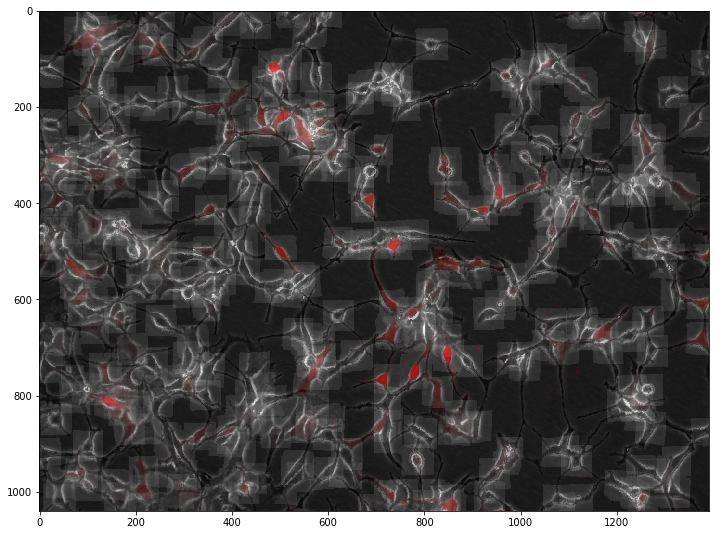

In [30]:
plt.figure(figsize = (12, 10))
alpha = 0.6
beta = (1.0 - alpha)
dst = cv2.addWeighted(cells,
                      alpha, cv2.cvtColor(((rslt['cell_map']/rslt['cell_map'].max().max())*255).astype(np.uint8),
                                          cv2.COLOR_GRAY2RGB), beta, 0.0)
plt.imshow(dst);

Visualization of a microphotograph with the redundant count map for red cells (overlayed).

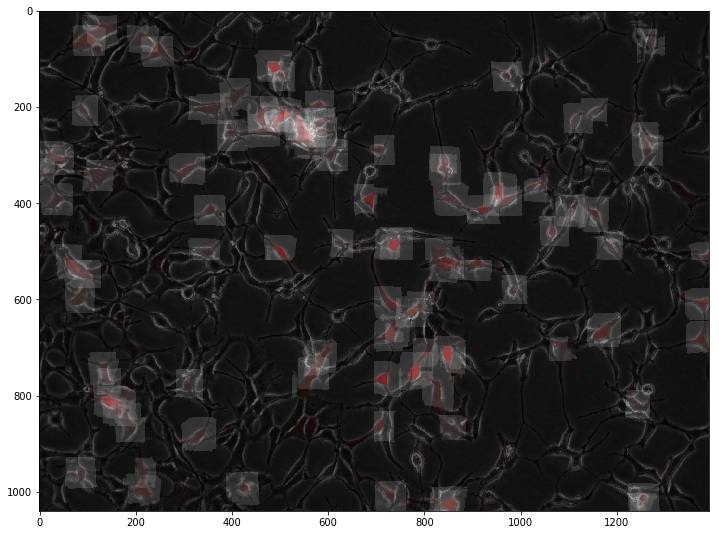

In [31]:
plt.figure(figsize = (12, 10))
alpha = 0.4
beta = (1.0 - alpha)
dst = cv2.addWeighted(cells,
                      alpha, cv2.cvtColor(((rslt['red_map']/rslt['red_map'].max().max())*255).astype(np.uint8),
                                          cv2.COLOR_GRAY2RGB), beta, 0.0)
plt.imshow(dst);

### 2. Using the web version

In [7]:
import requests ## a package for web requests
import base64   ## a package for converting the images into Base64 string

In [8]:
path2image = './test2018_03_28_14_25_36_75_fl.tif'
with open(path2image, "rb") as image_file: ## open the image
    encoded_string = base64.b64encode(image_file.read()) ## encode it into Base64 string

In [9]:
## prepare the query in JSON format
query = '''{
    "id": 1,
    "jsonrpc": "2.0",
    "method": "count_red_cells",
    "params": {''' + \
f'        "image" : "{encoded_string.decode("utf-8")}", ' +\
'''        "red_intensity_lower": 50 } }'''

In [10]:
url = 'http://cellcounter.nprog.ru/api' ## CellCounterCV API URL
headers = {'Content-Type': 'application/json'} ## headers for request

In [23]:
%%time
response = requests.post(url, data=query, headers = headers) ## post the request and measure the time

Wall time: 7.28 s


In [24]:
response.json() ## the response is in JSON format
## it's self-explanatory

{'jsonrpc': '2.0',
 'result': {'global_cell_count': 327.6265384615385,
  'percentage_of_red_cells': 27.246290944814945,
  'red_cell_count': 89.26607988165681},
 'id': 1}

In [25]:
## let's compare with our local results:
rslt['all_cells']

327.62656852045944

In [28]:
from sinfo import sinfo
sinfo()